In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)

## Dataset

El dataset de penguins es un conjunto de datos clásico y popular, similar al dataset de iris. Su objetivo principal es la clasificación, basándose en atributos físicos para identificar la especie de un pingüino.

**Descripción del Dataset**
- Registros: Contiene 344 observaciones de pingüinos de la familia Adelie, Gentoo y Chinstrap.
- Propósito: Es ideal para practicar con algoritmos de clasificación y análisis exploratorio de datos (EDA), ya que las especies están bien separadas por sus características físicas.

In [2]:
# ============================================================
# CARGA DEL DATASET penguins
# ============================================================

peng = sns.load_dataset("penguins")
print("Shape:", peng.shape)

print("\nValores faltantes por columna:")
print(peng.isna().sum())

Shape: (344, 7)

Valores faltantes por columna:
species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64


In [3]:
peng.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


## Descripción de las variables

El dataset consta de 7 variables, que incluyen atributos demográficos y mediciones físicas.

- species: La especie del pingüino. Es la variable objetivo para la clasificación. Tiene tres valores posibles: Adelie, Gentoo y Chinstrap.
- island: La isla donde se encontró el pingüino. Los valores posibles son Torgersen, Biscoe y Dream.
- bill_length_mm: La longitud del pico del pingüino en milímetros.
- bill_depth_mm: La profundidad del pico del pingüino en milímetros.
- flipper_length_mm: La longitud de la aleta del pingüino en milímetros.
- body_mass_g: La masa corporal del pingüino en gramos.
- sex: El sexo del pingüino (macho o hembra)

/tmp/ipykernel_9553/3559482688.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=species_counts.index, y=species_counts.values, palette='Set2')


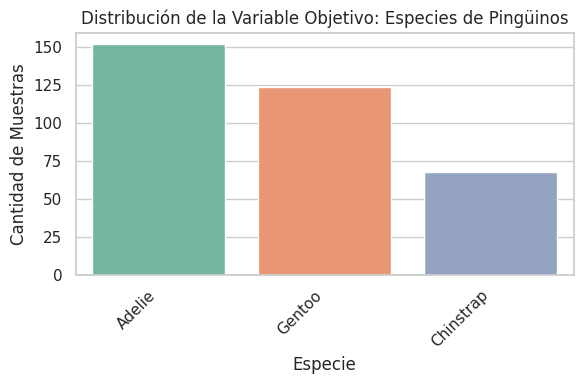

In [4]:
# ============================================================
# VARIABLE OBJETIVO
# ============================================================
species_counts = peng['species'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=species_counts.index, y=species_counts.values, palette='Set2')
plt.title('Distribución de la Variable Objetivo: Especies de Pingüinos')
plt.xlabel('Especie')
plt.ylabel('Cantidad de Muestras')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
# ============================================================
# SELECCIÓN Y LIMPIEZA DE VARIABLES
# ============================================================
num_cols = ['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']
df = peng[num_cols].copy()

# Eliminamos filas con valores faltantes
df = df.dropna()
print(f"Filas tras limpieza: {df.shape[0]}")

# Escalado para evitar dominancia de magnitudes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(X_scaled, columns=df.columns)
df_scaled.head()

Filas tras limpieza: 342


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,-0.884499,0.785449,-1.418347,-0.564142
1,-0.811126,0.126188,-1.062250,-0.501703
2,-0.664380,0.430462,-0.421277,-1.188532
3,-1.324737,1.089724,-0.563715,-0.938776
4,-0.847812,1.748985,-0.777373,-0.689020


### Escalado
K-Means usa distancias euclídeas, por lo que todas las variables deben estar en la misma escala.
Si no se escalan, variables grandes (como el peso corporal) dominarán la asignación de clusters.

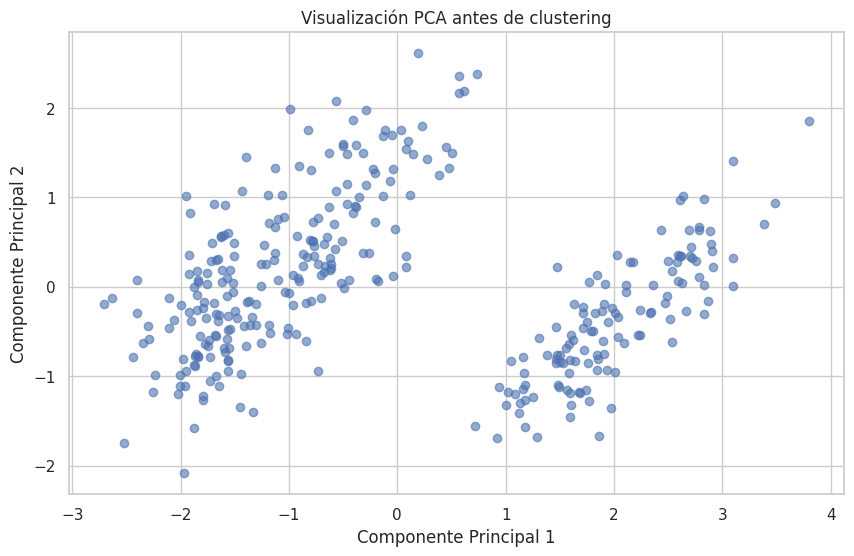

In [6]:
# ============================================================
# EXPLORACIÓN VISUAL PREVIA (PCA)
# ============================================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.6)
plt.title("Visualización PCA antes de clustering")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

### Visualización PCA 2D

Antes de aplicar clustering, es útil observar la estructura de los datos reducida a 2D.
El PCA nos muestra posibles agrupaciones naturales (clusters latentes).
En este caso, se aprecia cierta separación en el espacio proyectado: indicio de que K-Means podría encontrar grupos coherentes.

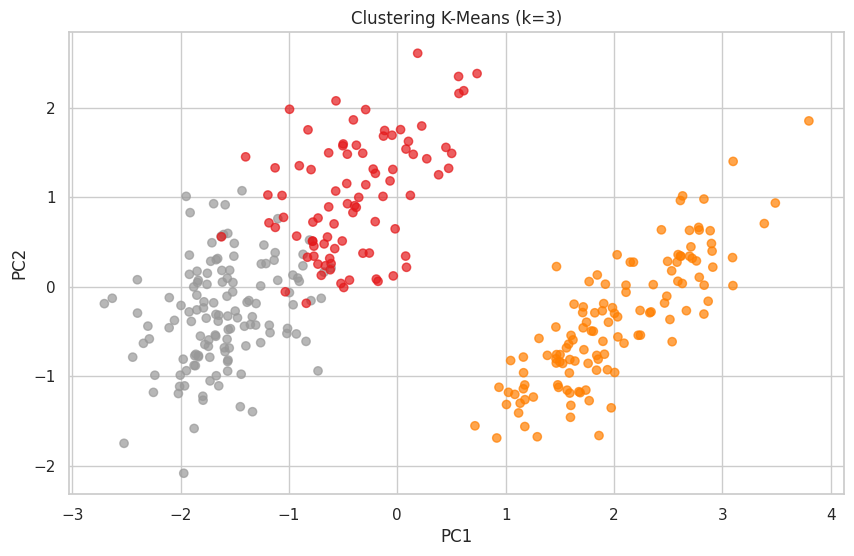

In [7]:
# ============================================================
# APLICACIÓN DE K-MEANS CON k=3 (inicial)
# ============================================================
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

df['Cluster'] = labels
centroids = kmeans.cluster_centers_

# Visualización en PCA
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='Set1', alpha=0.7)
plt.title("Clustering K-Means (k=3)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Ejecutamos K-Means con k=3, siguiendo la idea de que hay tres especies (tres posibles subgrupos biológicos).
Cada punto se asigna al cluster cuyo centroide esté más cercano.
Observa los grupos de color: aunque el algoritmo no conoce las especies, identifica naturalmente estructuras similares.

In [8]:
# ============================================================
# MÉTRICAS DE EVALUACIÓN INTERNA
# ============================================================
sil = silhouette_score(X_scaled, labels)
dbi = davies_bouldin_score(X_scaled, labels)
ch = calinski_harabasz_score(X_scaled, labels)

print(f"Silhouette: {sil:.3f}")
print(f"Davies-Bouldin: {dbi:.3f}")
print(f"Calinski-Harabasz: {ch:.1f}")

Silhouette: 0.447
Davies-Bouldin: 0.944
Calinski-Harabasz: 441.7


### Metricas

**Silhouette Score: 0.447**
- Significado: Mide la cohesión de los puntos dentro de sus propios clústeres y su separación de los clústeres vecinos. Un valor alto (cercano a 1) es ideal.

- Análisis: Un Silhouette Score de 0.447 es una puntuación buena. Nos dice que los clústeres son bastante cohesivos y están razonablemente bien separados. Aunque no es una puntuación excepcional, es sólida y sugiere que el algoritmo ha encontrado una estructura significativa en los datos.

**Davies-Bouldin Index: 0.944**
- Significado: Mide la relación entre la dispersión dentro de los clústeres y la distancia entre ellos. Un valor bajo (cercano a 0) es ideal.

- Análisis: Un Davies-Bouldin Index de 0.944 es un resultado excelente. Los valores por debajo de 1 generalmente se consideran una indicación de clústeres compactos y bien separados. Este valor confirma que los clústeres son distintivos y no se superponen.

**Calinski-Harabasz Index: 441.7**
- Significado: Mide la relación entre la varianza entre los clústeres y la varianza dentro de los clústeres. Un valor alto es ideal.

- Análisis: Al igual que el Davies-Bouldin Index, este valor es un indicativo de la calidad de la agrupación. Un valor alto como 441.7 sugiere que la varianza entre los clústeres es significativamente mayor que la varianza interna. En otras palabras, los grupos están muy bien separados entre sí y los puntos dentro de cada grupo están bastante cerca.

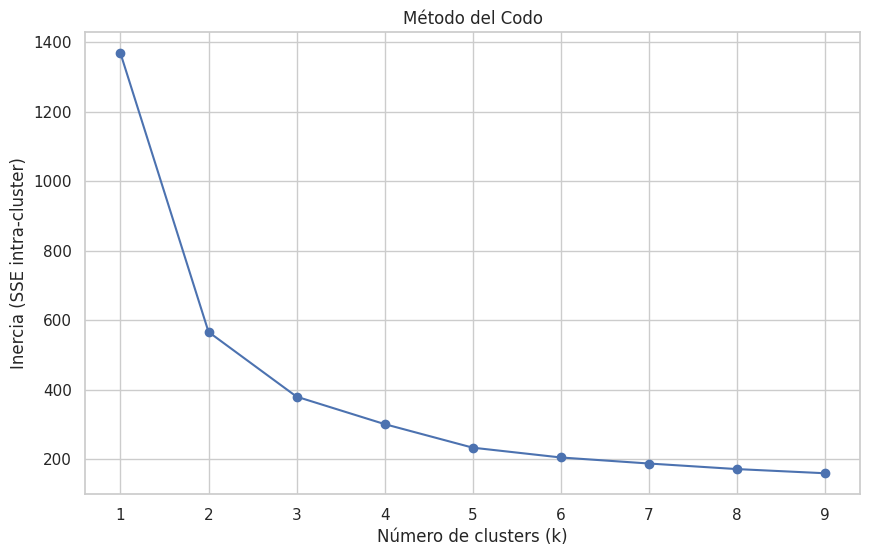

In [9]:
# ============================================================
# ELECCIÓN DEL NÚMERO DE CLUSTERS (Método del Codo)
# ============================================================
inertias = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(K, inertias, 'o-')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (SSE intra-cluster)")
plt.title("Método del Codo")
plt.show()

El método del codo muestra cómo la inercia (SSE) disminuye al aumentar k.
El “codo” indica el punto donde añadir más clusters deja de mejorar significativamente la compactación.

### Interpretación del gráfico
El objetivo es encontrar el punto de inflexión, o "codo", en la curva. Este es el punto donde la inercia deja de disminuir significativamente. Después del codo, añadir más clústeres no aporta una mejora sustancial a la cohesión de la agrupación.

- De k=1 a k=2: Hay una caída muy grande en la inercia. Esto nos dice que una división en dos clústeres mejora drásticamente la cohesión de los grupos.

- De k=2 a k=3: La inercia sigue disminuyendo, pero la tasa de caída es mucho menos pronunciada. Aquí es donde se encuentra el "codo" más claro de la curva.

- De k=3 en adelante: A partir de k=3, la curva se vuelve mucho más plana. Esto significa que los beneficios de añadir más clústeres son marginales. La inercia sigue bajando, pero a un ritmo mucho más lento, lo que indica que el modelo está fragmentando los clústeres existentes en lugar de encontrar una nueva estructura de datos.

### Conclusión
El análisis del gráfico del codo sugiere que el número óptimo de clústeres para este dataset es k=3. Este valor no solo es el punto de inflexión visual en la gráfica, sino que también coincide con el número real de especies en el dataset de pingüinos, lo que valida la elección y demuestra que K-Means ha sido capaz de encontrar la estructura subyacente de los datos.

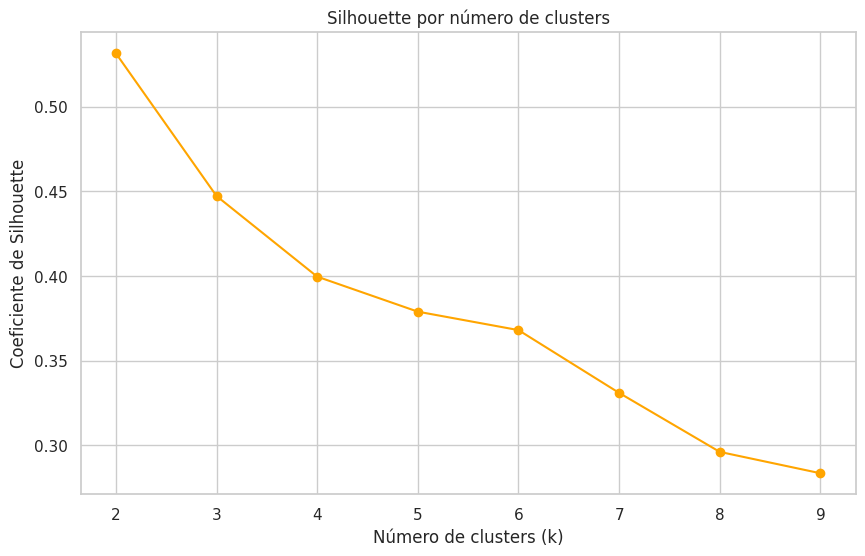

In [10]:
# ============================================================
# COEFICIENTE DE SILHOUETTE PARA VARIOS k
# ============================================================
sil_scores = []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels_k)
    sil_scores.append(sil)

plt.plot(range(2,10), sil_scores, 'o-', color='orange')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Coeficiente de Silhouette")
plt.title("Silhouette por número de clusters")
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.5315403219473027
For n_clusters = 3 The average silhouette_score is : 0.4472192983966046
For n_clusters = 4 The average silhouette_score is : 0.400207905186574


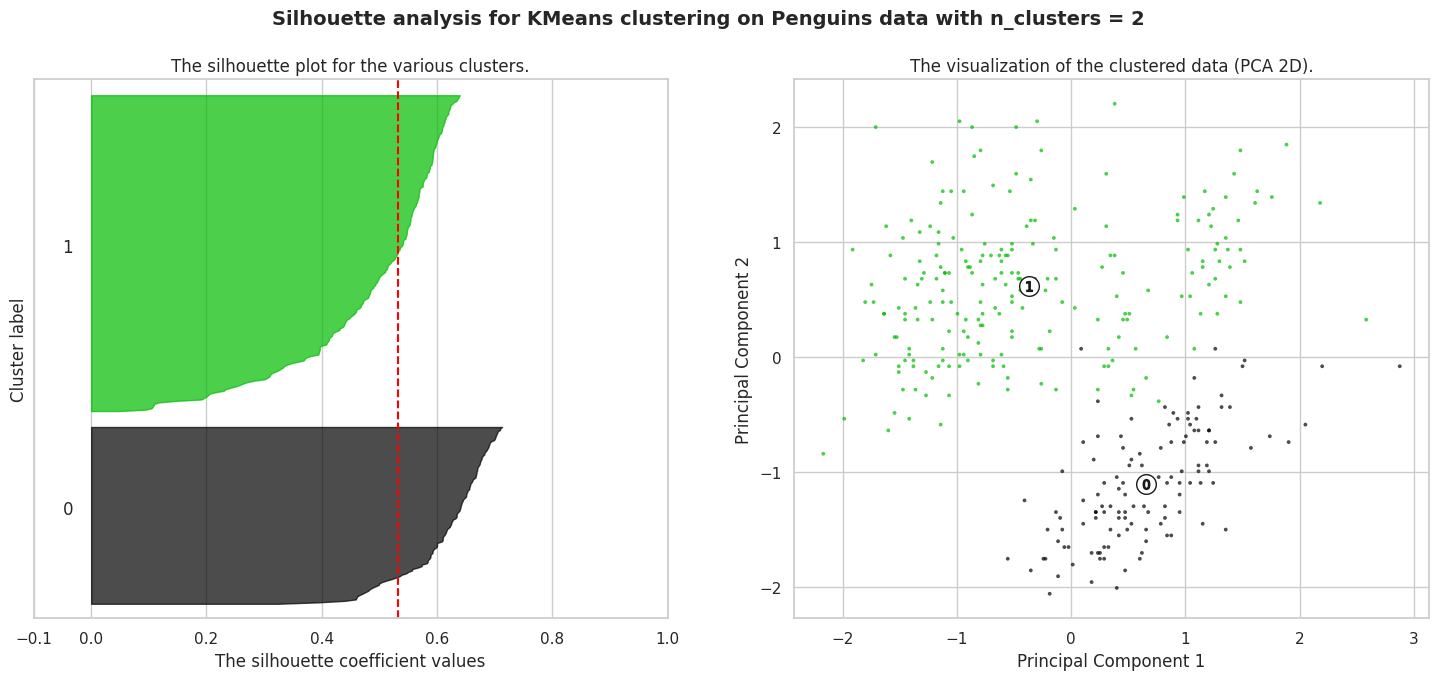

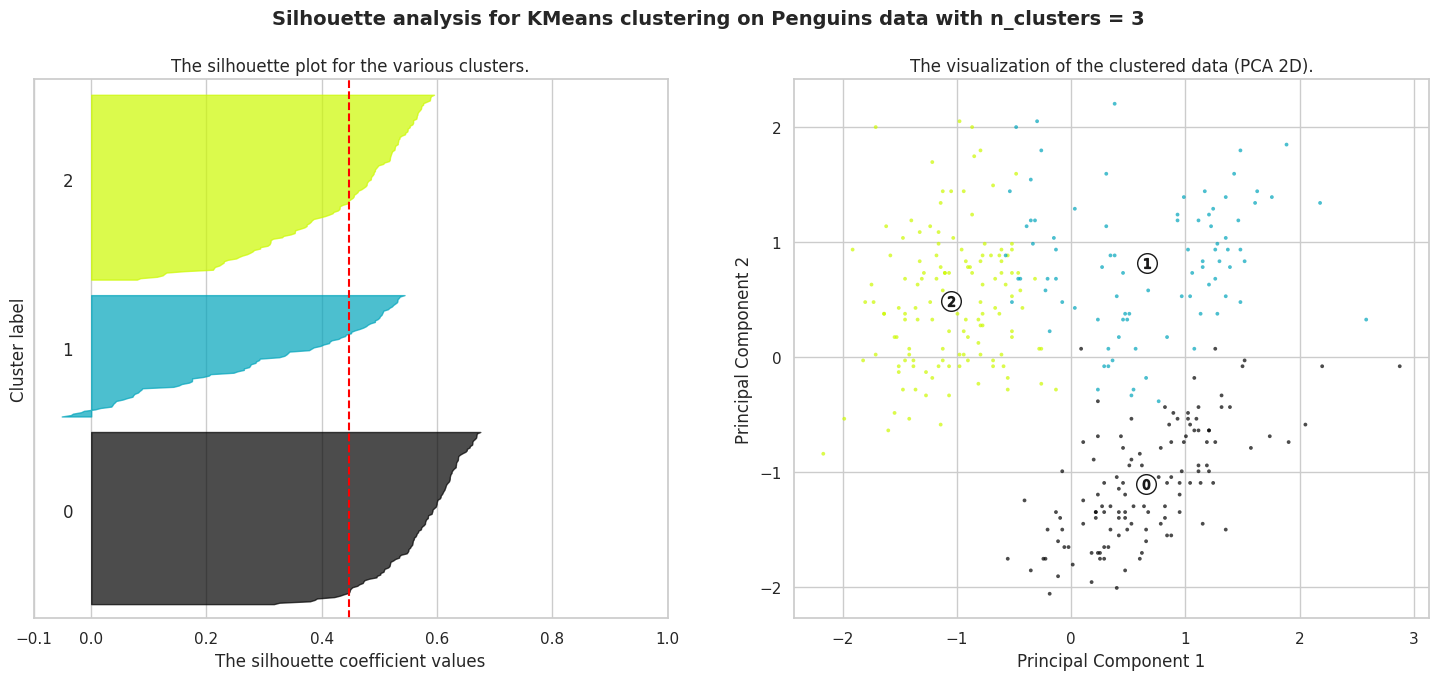

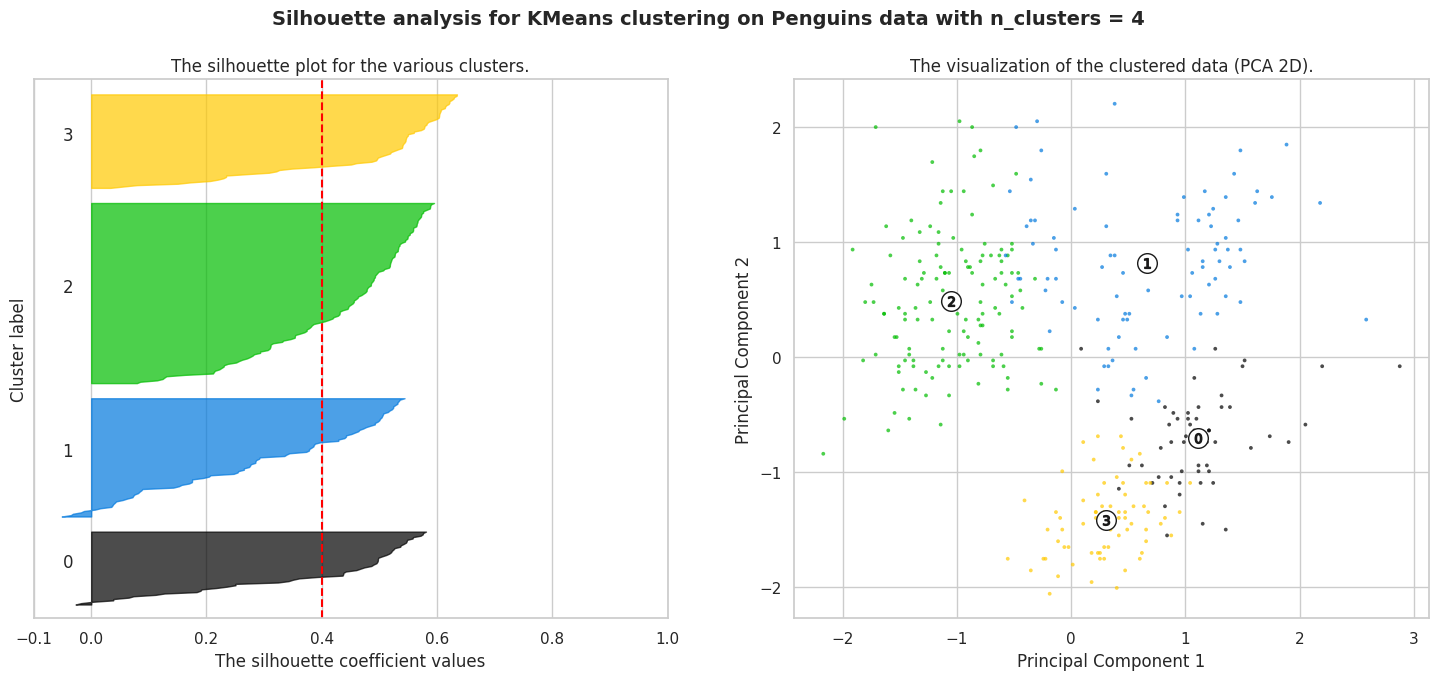

In [11]:
range_n_clusters = [2, 3, 4] 
X = X_scaled.copy()

# --- SILHOUETTE ANALYSIS LOOP ---
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # 1st subplot: Silhouette Plot Setup
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10]) 

    # Initialize the clusterer
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init='auto') 
    cluster_labels = clusterer.fit_predict(X) 

    # Calculate and print the average silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # --- Draw Silhouette Plot (ax1) ---
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # --- Draw Cluster Visualization (ax2) ---
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k') # Use NumPy array indexing

    # Labeling the clusters and drawing centers
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data (PCA 2D).")
    ax2.set_xlabel("Principal Component 1")
    ax2.set_ylabel("Principal Component 2")

    plt.suptitle((f"Silhouette analysis for KMeans clustering on Penguins data "
                  f"with n_clusters = {n_clusters}"),
                 fontsize=14, fontweight='bold')
    plt.savefig(f'silhouette_analysis_k{n_clusters}.png')

plt.show()

In [12]:
# ============================================================
# ANÁLISIS DE CLUSTERS (k óptimo = 3)
# ============================================================
df['Cluster'] = labels
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=num_cols)
display(df.groupby('Cluster')[num_cols].mean().round(1))



,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
Cluster,,,,
0,47.5,18.8,196.9,3902.0
1,47.5,15.0,217.2,5076.0
2,38.2,18.1,188.4,3584.7


### Descripción de los Clústeres (Tabla de Medias)
La tabla de medias nos da las características promedio de cada uno de los 3 clústeres. Usando estos valores, podemos dar un "nombre" a cada grupo:

- **Clúster 0 (Pico Largo, Masa Media):**

    - Pico: Longitud de 47.5 mm y profundidad de 18.8 mm.
    - Aleta: Longitud de 196.9 mm.
    - Masa corporal: 3902 gramos.
    - Perfil: Este grupo se caracteriza por tener un pico largo y relativamente delgado, una aleta de tamaño intermedio y una masa corporal media.

- **Clúster 1 (Pico Muy Largo, Masa Grande):**

    - Pico: Longitud de 47.5 mm y profundidad de 15.0 mm.
    - Aleta: Longitud de 217.2 mm.
    - Masa corporal: 5076 gramos.
    - Perfil: Este es el grupo más grande de pingüinos. Tienen el pico más largo, la aleta más larga y la mayor masa corporal.

- **Clúster 2 (Pico Corto, Masa Pequeña):**

    - Pico: Longitud de 38.2 mm y profundidad de 18.1 mm.
    - Aleta: Longitud de 188.4 mm.
    - Masa corporal: 3584.7 gramos.
    - Perfil: Este es el grupo más pequeño. Se distinguen por tener el pico y las aletas más cortas, además de la menor masa corporal.

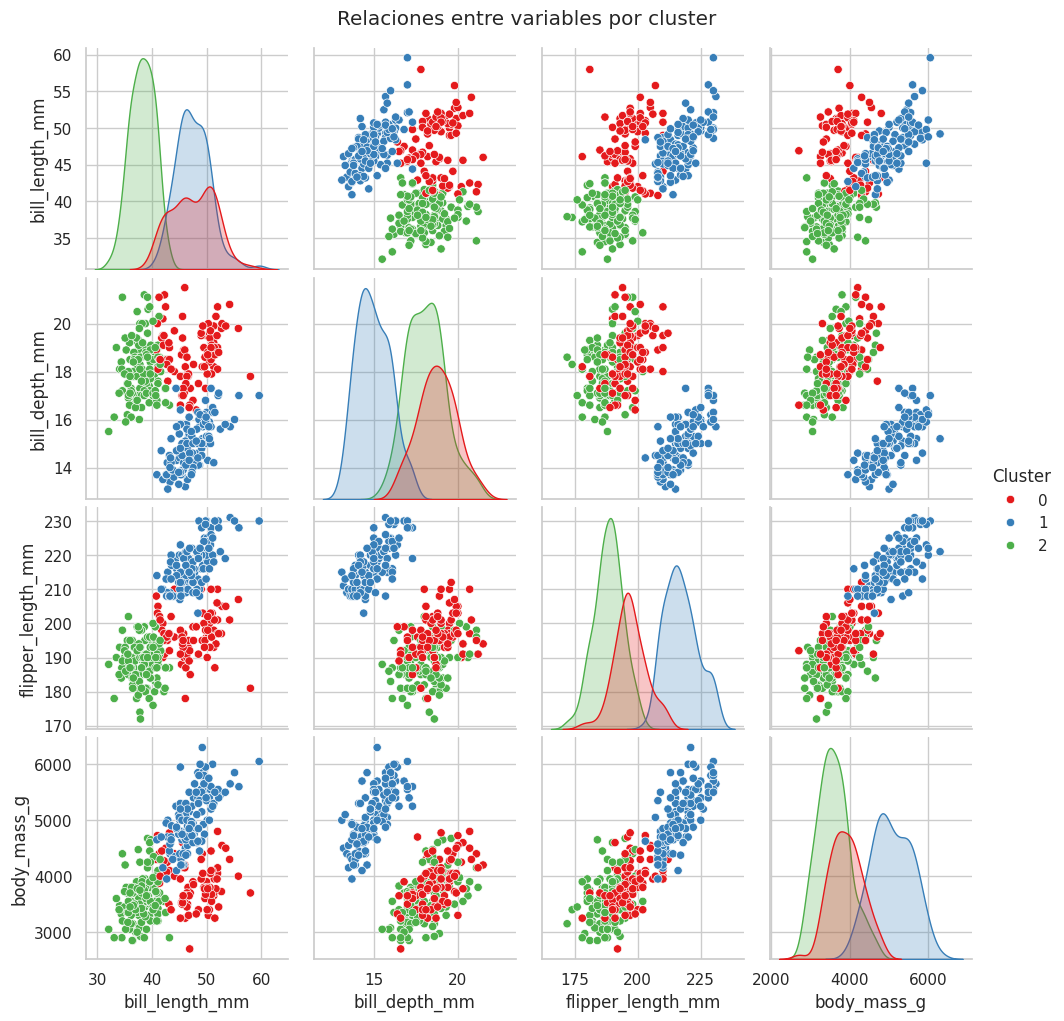

In [13]:
### PAIRPLOT
sns.pairplot(df, hue='Cluster', vars=num_cols, palette='Set1')
plt.suptitle("Relaciones entre variables por cluster", y=1.02)
plt.show()

### Análisis del Pairplot por Clúster
El pairplot permite ver visualmente cómo estos clústeres se han formado y cómo se superponen o separan entre sí.

- La separación más clara: Observa el gráfico de dispersión de bill_length_mm vs. bill_depth_mm. Aquí, los tres clústeres están muy bien definidos y separados. Esto nos dice que las dimensiones del pico son las características más importantes para distinguir a los tres grupos de pingüinos.
- Separación en otras variables: En el gráfico de body_mass_g vs. flipper_length_mm, también vemos una clara separación. El clúster 1 se encuentra en la parte superior derecha, lo que confirma que estos pingüinos son los más grandes. Los otros dos clústeres, aunque se superponen un poco, también son distinguibles.
- Distribuciones: Los histogramas en la diagonal (los gráficos de una sola variable) muestran que las distribuciones de los clústeres son bastante claras, especialmente para la masa corporal y la longitud de la aleta.

### Conclusión:
- El pairplot nos dice por qué: la biometría de los pingüinos (especialmente las dimensiones del pico y la masa corporal) es un factor muy fuerte para identificar tres grupos distintos